## Environment Setup

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that.

</br>

**[FOR GOOGLE COLAB ONLY]** </br>
In case you're not using a GPU and you wish to use one, go to `Runtime` -> `Change runtime type` -> Select `T4 GPU` -> Click `Save`.

In [8]:
!nvidia-smi

zsh:1: command not found: nvidia-smi


In [9]:
import os
HOME = os.getcwd()
print(HOME)

/Users/rare/Desktop/segmentation-project


## Install YOLOv8

In [10]:
!pip install ultralytics

## Connect Drive

In [11]:
# from google.colab import drive
# drive.mount('/gdrive')

## Import Packages

In [12]:
import os
import re
import sys
import time
import json
import yaml
import requests
import math

import cv2
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image, ImageChops

import ultralytics
from ultralytics import YOLO

## Run Checks

In [13]:
ultralytics.checks()

Ultralytics YOLOv8.0.211 🚀 Python-3.11.5 torch-2.1.0 CPU (Intel Core(TM) i7-9750H 2.60GHz)
Setup complete ✅ (12 CPUs, 16.0 GB RAM, 220.7/233.5 GB disk)


## Helper Functions

In [14]:
def plot_imgs(imgs, titles=None, n_rows=1, fig_width=5,
              fig_height=10, title_size=12, title_color='black'):
  # Define a figure and its size
  figure = plt.figure(figsize=(fig_width, fig_height))

  # Loop over the number of images
  for i in range(len(imgs)):
    plt.subplot(n_rows, len(imgs) // n_rows, i+1)    # Create a subplot

    # Convert the colors of the images
    # Matplot reads CV2 RGB images as BGR for some reason
    if len(imgs[i].shape) == 3:
      img_matplot = cv2.cvtColor(imgs[i], cv2.COLOR_RGB2BGR)
      plt.imshow(img_matplot)
    else:
      img_matplot = imgs[i]
      plt.imshow(img_matplot, cmap="gray")

    # If there are titles, show them
    if titles:
        plt.title(titles[i], size=title_size, color=title_color)

    # Remove the X and Y ticks
    plt.xticks([])
    plt.yticks([])

In [15]:
def download_image(image_url, image_name):
  img_data = requests.get(image_url).content

  with open(f'{image_name}.jpg', 'wb') as handler:
      handler.write(img_data)

In [16]:
def plot_yolo_results(img, results):
    # Get a list of all the class names
    NAMES = ["person", "bicycle", "car", "motorbike", "aeroplane", "bus", "train", "truck", "boat", "traffic light", "fire hydrant", "stop sign", "parking meter", "bench", "bird", "cat", "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe", "backpack", "umbrella","handbag", "tie", "suitcase", "frisbee", "skis", "snowboard", "sports ball", "kite", "baseball bat","baseball glove", "skateboard", "surfboard", "tennis racket", "bottle", "wine glass", "cup","fork", "knife", "spoon", "bowl", "banana", "apple", "sandwich", "orange", "broccoli","carrot", "hot dog", "pizza", "donut", "cake", "chair", "sofa", "pottedplant", "bed","diningtable", "toilet", "tvmonitor", "laptop", "mouse", "remote", "keyboard", "cell phone","microwave", "oven", "toaster", "sink", "refrigerator", "book", "clock", "vase", "scissors","teddy bear", "hair drier", "toothbrush" ]

    # Fetch the results
    result = results[0]

    # Make a copy of the original image
    img_out = img.copy()

    # Get the bounding boxes and labels from the result
    bbox_xyxys = result.boxes.xyxy.cpu()
    confidences = result.boxes.conf
    labels = result.boxes.cls

    # Loop over the results
    for (bbox_xyxy, confidence, cls) in zip(bbox_xyxys, confidences, labels):
        # Extract the bounding boxes
        bbox = np.array(bbox_xyxy)
        x1, y1, x2, y2 = bbox[0], bbox[1], bbox[2], bbox[3]
        x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)

        # Extract the class names and labels
        classname = int(cls)
        class_name = NAMES[classname]
        conf = math.ceil((confidence*100))/100
        label = f'{class_name}{conf}'

        # Set text size for labels
        t_size = cv2.getTextSize(label, 0, fontScale = 1, thickness=2)[0]
        c2 = x1 + t_size[0], y1 - t_size[1] - 3

        # Draw bounding boxes
        cv2.rectangle(img_out, (x1, y1), c2, (100, 185, 20), -1, cv2.LINE_AA)

        # Draw text
        cv2.putText(img_out, label, (x1, y1-2), 0, 1, (255, 255, 255), thickness=2, lineType=cv2.LINE_AA)

        # Draw rectangle over the text
        cv2.rectangle(img_out, (x1, y1), (x2, y2), (100, 185, 20), 3)

    plot_imgs([img_out], [f'YOLOv8s Segmentation Output'], fig_width=10, fig_height=10)

# Inference with Pre-trained COCO Model

## 🐍 Download Model

In [17]:
# The chosen model is YOLOv8_Large
model = YOLO(f'{HOME}/yolov8l-seg.pt')

100%|██████████| 88.1M/88.1M [09:02<00:00, 170kB/s]   


## Run Predictions

### Using Image URL

In [18]:
# Note that we feed the model a URL (ending with .jpg, .jpeg, or .png)
IMG_URL = 'two-cows.jpg'

# Run the model on the image URL and save it in `runs/segment/predict`
results = model.predict(source=IMG_URL, conf=0.25, save=True)


image 1/1 /Users/rare/Desktop/segmentation-project/two-cows.jpg: 448x640 2 cows, 1880.7ms
Speed: 11.4ms preprocess, 1880.7ms inference, 28.7ms postprocess per image at shape (1, 3, 448, 640)
Results saved to runs/segment/predict


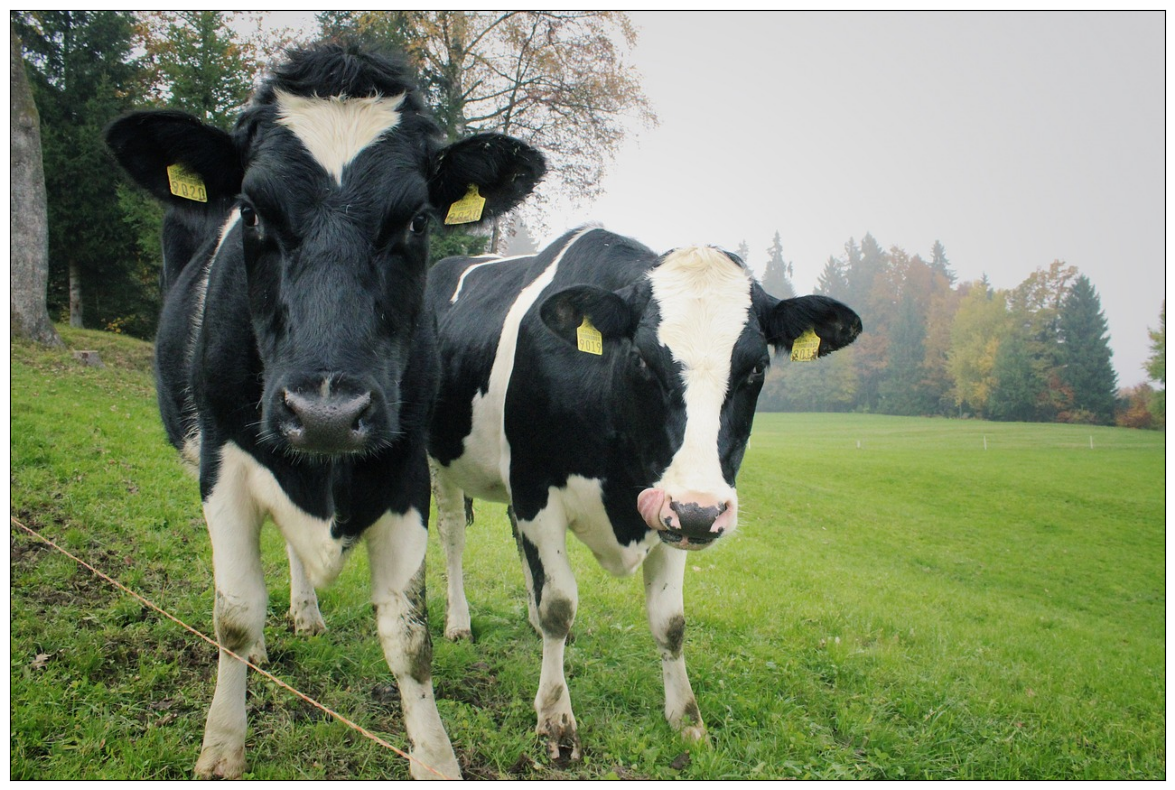

In [19]:
# Read the result image and plot it
plot_imgs([cv2.imread('two-cows.jpg')], fig_width=20)

## Using Local Image

In [44]:
# Define the image URL [TO BE REPLACED WITH YOUR OWN IMAGE URL]
IMG_URL = 'two-cows.jpg'

# First, download the same image and save it locally
download_image(IMG_URL, 'cow_seg.jpg')

MissingSchema: Invalid URL 'two-cows.jpg': No scheme supplied. Perhaps you meant https://two-cows.jpg?

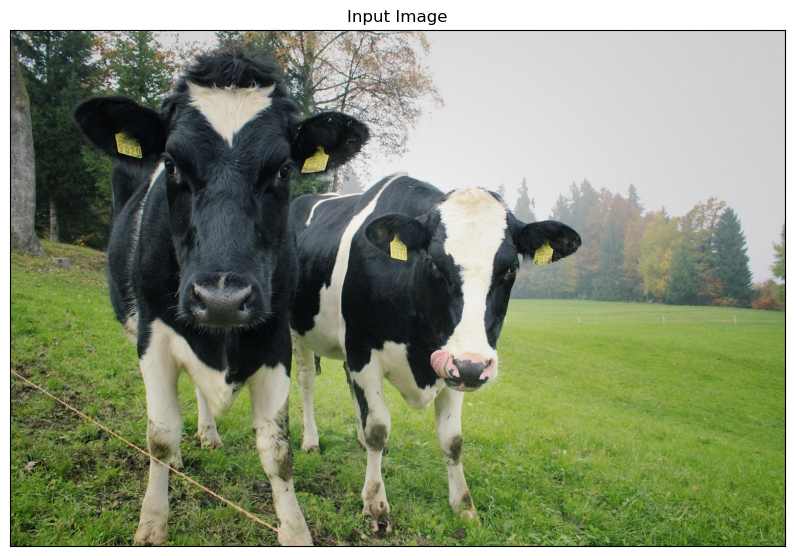

In [31]:
# Define the image path [TO BE REPLACED WITH YOUR OWN IMAGE PATH]
IMG_PATH = 'two-cows.jpg'

# Read the image
input_img = cv2.imread(IMG_PATH)

# Plot the input image
plot_imgs([input_img], ['Input Image'], fig_width=10, fig_height=10)

In [32]:
# Run model on local image
# Note that now we feed the model the image itself, not a URL
img = input_img.copy()
results = model.predict(source=img, conf=0.25)


0: 448x640 2 cows, 1758.9ms
Speed: 2.9ms preprocess, 1758.9ms inference, 2.2ms postprocess per image at shape (1, 3, 448, 640)


## Results Analysis

In [42]:
result = results[0]

In [34]:
# Get bounding boxes coordinates (normalised)
result.boxes.xyxy

tensor([[101.7994,  35.5878, 595.6139, 844.3920],
        [457.9039, 237.1071, 945.7531, 831.2903]])

In [35]:
# Get class confidences
result.boxes.conf

tensor([0.9675, 0.9562])

In [36]:
# Get class IDs
result.boxes.cls

tensor([19., 19.])

In [40]:
# Get masks
result.masks

ultralytics.engine.results.Masks object with attributes:

data: tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])
orig_shape: (853, 1280)
shape: torch.Size([2, 448, 640])
xy: [array([[        322,        42.5],
       [        320,        44.5],
       [        310,        44.5],
       ...,
       [        410,        44.5],
       [        400,        44.5],
       [        398,        42.5]], dtype=float32), array([[        624,       242.5],
       [        622,       244.5],
       [        616,       244.5],
      

## Plot Results

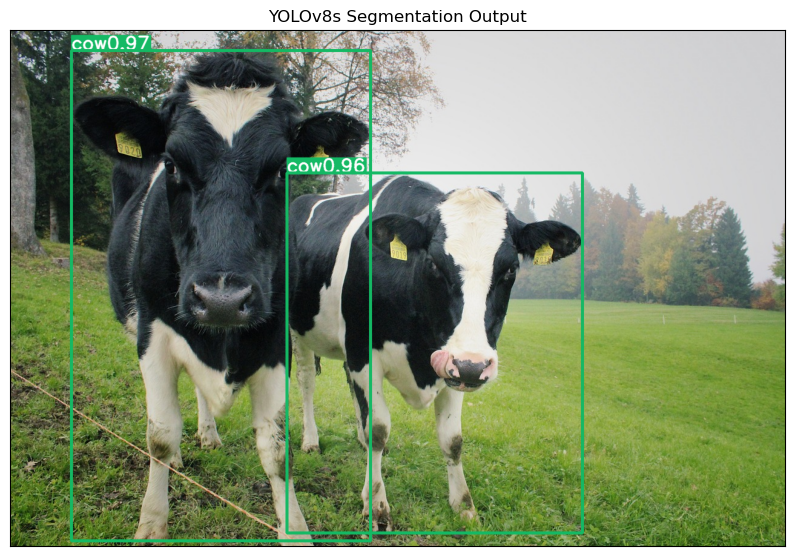

In [41]:
plot_yolo_results(img, results)

# Automate the system

In [ ]:
# TODO
def run_system(img):
    pass